In [1]:
import pandas as pd
import pickle5 as pickle
import numpy as np
from collections import defaultdict
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plot
import eval

pd.options.mode.chained_assignment = None # turns off pandas SettingWithCopyWarning

In [2]:
base_dir = '/Users/rhodos/Desktop/Projects/akbc2021/'
figure_dir = f'{base_dir}figures/submission_june_21/'
results_dir = f'{base_dir}explanations/linklogic/for_paper/true_false_nonsense/'

In [3]:
palette = plot.get_categorical_palette()

heuristic90 = 'Path score heuristic, 0.90'
heuristic95 = 'Path score heuristic, 0.95'

thresh95 = -np.log(0.05)
thresh90 = -np.log(0.1)

In [4]:
# read in pickle files and extract explanation size
experiments = {'nonsense': 'Nonsense',
               'false_facts': 'False Fact',
               'true_facts': 'True Fact'}
P = dict()
for experiment in experiments.keys():
    print(experiment)
    with open(f'{results_dir}/pickle_files/{experiment}.pickle', 'rb') as f:
        P[experiment] = pickle.load(f)

nonsense
false_facts
true_facts


In [5]:
# pull out relevant info into dataframe
rows = []
for exp, exp_long in experiments.items():
    print(exp_long)
    for triple in P[exp]:

        heuristic_paths_90 = [p for p in triple['linklogic_features'] if p['kge_score']['path_score'] > thresh90]
        heuristic_paths_95 = [p for p in triple['linklogic_features'] if p['kge_score']['path_score'] > thresh95]
        
        rows.append({
            'Query Triple Category': exp_long,
            'Query Triple': '--'.join(triple['query_triple']),
            'KGE Score': float(triple['query_triple_kge_score']),
            'linklogic Fidelity': triple['linklogic_metrics']['test_acc'],
            'Total Features Considered': len(triple['linklogic_features']),
            'linklogic': len(triple['linklogic_explanations']),
            'Path score heuristic, 0.90': len(heuristic_paths_90),
            'Path score heuristic, 0.95': len(heuristic_paths_95)
        })
data = pd.DataFrame(rows)
data = data.drop_duplicates()
data['relation'] = data['Query Triple'].apply(lambda x: x.split('--')[1])

data.shape
data.head()

Nonsense
False Fact
True Fact


(3894, 9)

,Query Triple Category,Query Triple,KGE Score,linklogic Fidelity,Total Features Considered,linklogic,"Path score heuristic, 0.90","Path score heuristic, 0.95",relation
0,Nonsense,josaphat_kuncevyc--nationality--george_e_burch,0.013099,-0.000271,109,0,3,1,nationality
1,Nonsense,blanka_of_namur--gender--friedrich_vii_margrav...,0.024888,-0.000198,151,0,3,3,gender
2,Nonsense,alpheus_baker--profession--martha_bulloch,0.019042,-0.001908,188,0,9,6,profession
3,Nonsense,tim_russert--ethnicity--davis_hanson_waite,0.022815,-0.000209,188,0,5,3,ethnicity
4,Nonsense,andy_bowen--place_of_birth--kadambini_ganguly,0.038236,-0.000322,139,0,5,4,place_of_birth


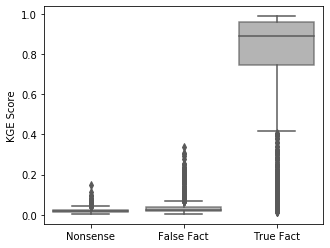

In [6]:
_ = plt.figure(figsize=(5,4))
g = sns.boxplot(data=data, x='Query Triple Category', y='KGE Score', color=palette['generic'], boxprops=dict(alpha=0.7))
_ = g.set(xlabel=None)
_ = g.get_figure().savefig(f'{figure_dir}quant_A.{plot.figtype}', bbox_inches='tight')

In [10]:
data.groupby('Query Triple Category')['KGE Score'].mean()

Query Triple Category
False Fact    0.034988
Nonsense      0.021119
True Fact     0.777588
Name: KGE Score, dtype: float64

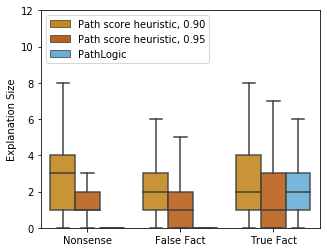

In [34]:
explain_size = pd.melt(data, id_vars=['Query Triple Category', 'Query Triple'], value_vars=['linklogic', 'Path score heuristic, 0.90', 'Path score heuristic, 0.95'])
explain_size.columns = ['Query Triple Category', 'Query Triple', 'Method', 'Explanation Size']

pal = {'Path score heuristic, 0.90': palette['Heuristic90'],
       'Path score heuristic, 0.95': palette['Heuristic95'],
       'linklogic': palette['linklogic']}

_ = plt.figure(figsize=(5,4))
g = sns.boxplot(data=explain_size, x='Query Triple Category', y='Explanation Size', 
                hue='Method', fliersize=0, palette=pal, boxprops=dict(alpha=.9), hue_order=pal.keys()) 
_ = g.set_ylim([0, 12]) 
_ = g.legend(loc='upper left')
_ = g.set(xlabel=None)
_ = g.get_figure().savefig(f'{figure_dir}quant_B.{plot.figtype}', bbox_inches='tight')

In [44]:
explain_size.groupby(['Method', 'Query Triple Category'])['Explanation Size'].mean()

Method                      Query Triple Category
Path score heuristic, 0.90  False Fact               2.034615
                            Nonsense                 2.854615
                            True Fact                4.055641
Path score heuristic, 0.95  False Fact               1.234615
                            Nonsense                 1.693846
                            True Fact                2.550232
linklogic                   False Fact               0.233077
                            Nonsense                 0.217692
                            True Fact                1.922720
Name: Explanation Size, dtype: float64

In [52]:
#explain_size.to_csv('explanation_size.tsv', sep='\t', index=False)
#data.to_csv('true_false_nonsense_triples_all_metrics.tsv', sep='\t', index=False)

In [49]:
tmp = pd.DataFrame(explain_size.groupby(['Query Triple', 'Query Triple Category'], as_index=False))
tmp

,0,1
0,"(a_starker_leopold--place_of_birth--ossining, ...",Query Triple Category ...
1,"(aaron_bancroft--place_of_death--haddington, F...",Query Triple Category ...
2,(aaron_s_daggett--place_of_birth--silent_film_...,Query Triple Category ...
3,"(aaron_sapiro--spouse--aberdeenshire, Nonsense)",Query Triple Category ...
4,"(aatsista-mahkan--ethnicity--blackfoot, True F...",Query Triple Category ...
...,...,...
3889,"(zhou_jichang--ethnicity--portuguese_american,...",Query Triple Category ...
3890,"(ziaur_rahman--location--boudica, Nonsense)",Query Triple Category ...
3891,"(zoltan_kodaly--place_of_birth--kecskemet, Tru...",Query Triple Category ...
3892,"(zygmunt_krasinski--profession--lawyer, False ...",Query Triple Category ...


In [54]:
data.groupby(['Query Triple Category'])['linklogic Fidelity'].mean()

Query Triple Category
False Fact    0.014266
Nonsense      0.016307
True Fact     0.291351
Name: linklogic Fidelity, dtype: float64

In [57]:
data.head()

,Query Triple Category,Query Triple,KGE Score,linklogic Fidelity,Total Features Considered,linklogic,"Path score heuristic, 0.90","Path score heuristic, 0.95",relation,relation_category
0,Nonsense,josaphat_kuncevyc--nationality--george_e_burch,0.013099,-0.000271,109,0,3,1,nationality,Location
1,Nonsense,blanka_of_namur--gender--friedrich_vii_margrav...,0.024888,-0.000198,151,0,3,3,gender,Other
2,Nonsense,alpheus_baker--profession--martha_bulloch,0.019042,-0.001908,188,0,9,6,profession,Other
3,Nonsense,tim_russert--ethnicity--davis_hanson_waite,0.022815,-0.000209,188,0,5,3,ethnicity,Other
4,Nonsense,andy_bowen--place_of_birth--kadambini_ganguly,0.038236,-0.000322,139,0,5,4,place_of_birth,Location


In [64]:
nonsense = data.loc[data['Query Triple Category'] == 'Nonsense', 'linklogic Fidelity']
false_fact = data.loc[data['Query Triple Category'] == 'False Fact', 'linklogic Fidelity']
true_fact = data.loc[data['Query Triple Category'] == 'True Fact', 'linklogic Fidelity']

In [65]:
from scipy.stats import ttest_ind

In [67]:
len(true_fact)

1294

In [68]:
ttest_ind(true_fact, false_fact)

Ttest_indResult(statistic=36.044590034649914, pvalue=5.673057519794053e-231)

In [35]:
explain_size['positive'] = explain_size['Explanation Size'] > 0
explain_stats_pos = explain_size.groupby(['Method', 'Query Triple Category', 'Query Triple'], as_index=False)['positive'].any()
explain_stats_pos = explain_stats_pos.groupby(['Method', 'Query Triple Category'], as_index=False)['positive'].sum()

explain_size['all'] = explain_size['Explanation Size'] >= 0
explain_stats_all = explain_size.groupby(['Method', 'Query Triple Category', 'Query Triple'], as_index=False)['all'].any()
explain_stats_all = explain_stats_all.groupby(['Method', 'Query Triple Category'], as_index=False)['all'].sum()

explain_stats = explain_stats_pos.merge(explain_stats_all, on=['Method', 'Query Triple Category'], how='left')

explain_stats['percent'] = 100 * (explain_stats['positive'] / explain_stats['all'])

explain_stats

,Method,Query Triple Category,positive,all,percent
0,"Path score heuristic, 0.90",False Fact,1077,1300,82.846154
1,"Path score heuristic, 0.90",Nonsense,1178,1300,90.615385
2,"Path score heuristic, 0.90",True Fact,1070,1294,82.689335
3,"Path score heuristic, 0.95",False Fact,810,1300,62.307692
4,"Path score heuristic, 0.95",Nonsense,998,1300,76.769231
5,"Path score heuristic, 0.95",True Fact,856,1294,66.151468
6,linklogic,False Fact,132,1300,10.153846
7,linklogic,Nonsense,168,1300,12.923077
8,linklogic,True Fact,980,1294,75.734158


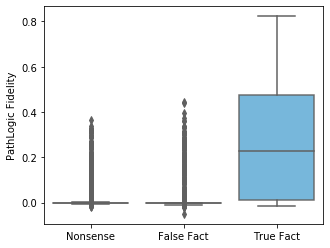

In [36]:
_ = plt.figure(figsize=(5,4))
g = sns.boxplot(data=data, x='Query Triple Category', y='linklogic Fidelity', color=palette['linklogic'], boxprops=dict(alpha=0.9))
_ = g.set(xlabel=None)
_ = g.get_figure().savefig(f'{figure_dir}quant_C_simple.{plot.figtype}', bbox_inches='tight')

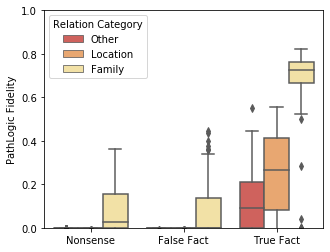

In [76]:
relation_categories = {
    'Other': ['cause_of_death', 'ethnicity', 'gender', 'institution', 'profession', 'religion'],
    'Location': ['location', 'place_of_birth', 'place_of_death', 'nationality'],
    'Family': ['children', 'spouse', 'parents']}
rel_dict = {}
for key, values in relation_categories.items():
    for val in values:
        rel_dict[val] = key
data['relation_category'] = data['relation'].map(rel_dict)


pal = plot.get_sequential_palette(name='Spectral')
_ = plt.figure(figsize=(5,4))
g = sns.boxplot(data=data, x='Query Triple Category', y='linklogic Fidelity', hue='relation_category', 
                hue_order = ['Other', 'Location', 'Family'], palette=pal)
_ = g.legend(loc='upper left', title='Relation Category')
_ = g.set_ylim([0, 1]) 
_ = g.set(xlabel=None)
_ = g.get_figure().savefig(f'{figure_dir}quant_C.{plot.figtype}', bbox_inches='tight')

In [38]:
# load explanations
results_dir = '../../explanations/linklogic/full_parents_benchmark/'
figure_dir = '../../figures/figures_for_paper/'

with open(f'{results_dir}/fb13_child_false.pickle', 'rb') as f:
    results = pickle.load(f)

In [39]:
# load benchmark
with open('../../data/commonsense_benchmark/v4/commonsense_benchmark_all.json', 'r') as f:
    benchmark = json.load(f)
    
print(f'Loaded benchmark with {len(benchmark)} triples')

Loaded benchmark with 6260 triples


In [40]:
rows = []
for i, bmk in tqdm(enumerate(benchmark), total=len(benchmark)):
    triple = bmk['query_triple']

    res = eval.get_results_for_query_triple(results, triple)

    if not res:
        continue

    num_heuristic_paths_90 = sum([1 for f in res['linklogic_features'] if f['kge_score']['path_score'] > thresh90])
    num_heuristic_paths_95 = sum([1 for f in res['linklogic_features'] if f['kge_score']['path_score'] > thresh95])

    rows.append({
        'Query Triple': '--'.join(triple),
        'linklogic Fidelity': res['linklogic_metrics']['test_acc'],
        'Number of Siblings': len(bmk['entity_names']['siblings']),
        'num_paths_linklogic': len(res['linklogic_explanations']),
        'num_paths_heuristic_90': num_heuristic_paths_90,
        'num_paths_heuristic_95': num_heuristic_paths_95
    })
sibs = pd.DataFrame(rows)

100%|██████████| 6260/6260 [00:12<00:00, 486.47it/s]


<Figure size 360x288 with 0 Axes>

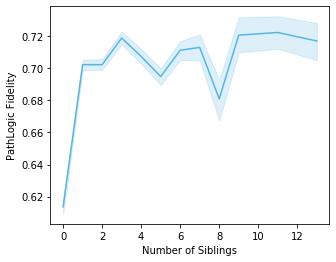

In [41]:
plt.figure(figsize=(5,4))
g = sns.lineplot(data=sibs, x='Number of Siblings', y='linklogic Fidelity', color=palette['linklogic'])
_ = g.get_figure().savefig(f'{figure_dir}quant_F.{plot.figtype}', bbox_inches='tight')

<Figure size 360x288 with 0 Axes>

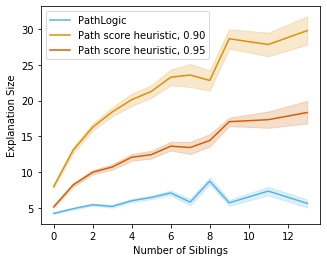

In [42]:
num_paths = sibs.melt(id_vars=['Query Triple', 'Number of Siblings'], value_vars=['num_paths_linklogic', 'num_paths_heuristic_90', 'num_paths_heuristic_95'])
num_paths['variable'] = num_paths['variable'].map({'num_paths_linklogic': 'linklogic', 
                           'num_paths_heuristic_90': heuristic90,
                           'num_paths_heuristic_95': heuristic95})

pal = plot.get_categorical_palette()
palette = {'linklogic': pal['linklogic'], heuristic90: pal['Heuristic90'], heuristic95: pal['Heuristic95'] }
plt.figure(figsize=(5,4))
g = sns.lineplot(data=num_paths, x='Number of Siblings', y='value', hue='variable', palette=palette)
_ = g.legend(title='')
_ = g.set(ylabel='Explanation Size')
g.get_figure().savefig(f'{figure_dir}quant_E.{plot.figtype}', bbox_inches='tight')